<a href="https://colab.research.google.com/github/Hilal-Urun/tensorflow_everyday/blob/main/TF_day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#today we are going to do text classification, first of all we are starting to classify plain text stored our disk
#and we are going to do sentiment analysis on IMDB dataset to classify movie reviews as possitive or negative
#before we start we need to import libraries we are going to use
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

In [2]:
#now we download our data and see directory structure and when we insall our data
#you can see our dataset in files and you can examine on exracted file named aclImdb and 
#when you look do data you will see its already splitted as training and testing data and 
#noth are includes positive and negative texts seperately.
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 2s 0us/step


In [3]:
#if we want to look one of the file ;
sample_file = os.path.join(dataset_dir, 'train/pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [4]:
#now before starting to build our model we need to prepare our data for training
#and we just need to negative and positive texts we just discard the others
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [5]:
#as you know when working with a machine learning task it is better to divide
#your dataset as 3 part as training, validation and test. our dataset already divided 
#to two parts like training and test and now we are going to split our traing set as 
#training and validation set with a ratio that %80 training data and %20 validation data 
#for avoiding the overlap we need to use random seed or instead of this we can use suffle=false  
batch_size = 32
seed = 42
raw_train_data = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
raw_validation_data = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [7]:
raw_test_data = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.



*   Before training we need to standardize, tokenize and vectorize our data
*   Standardization means that we need to clean our text data such as punctuation and html syntax.
*   Tokenization means that we are splitting our text to tokens like it's words and spaces
*   Vectorization means that we will convert our tokens to numbers to feed our neural network
*   All these can done by tf.keras.layers.TextVectorization layer but one thing to remember
*   We can not remove html tags with this layer, we need to write a custom function to clean our text data to html tags

In [8]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [9]:
#now we can use the tf.keras.layers.TextVectorization layer for standardize, tokenize and vectorize our text data
#we are setting our output mode to int for taking unique integer indeces for every token
max_features = 10000
sequence_length = 250
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [10]:
#adapt fits the state of the preprocessing layer to the dataset and this will cause the model to build an index of strings to integers.
train_text = raw_train_data.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [11]:
#before continue we will create a function and see the results of using this layer
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [12]:
text_batch, label_batch = next(iter(raw_train_data))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_data.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

As we can see above, each token replaced by an integer.We can also check specific numbers meaning in our tokens with calling get_vocabulary() on the layer, let's see!

In [13]:
print("1578 ---> ",vectorize_layer.get_vocabulary()[1578])
print("359 ---> ",vectorize_layer.get_vocabulary()[359])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1578 --->  finding
359 --->  production
Vocabulary size: 10000


In [14]:
#as our final preprocessing on our data we are going to apply vectorize_text to our train, validation and test data
train_data = raw_train_data.map(vectorize_text)
validation_data = raw_validation_data.map(vectorize_text)
test_data = raw_test_data.map(vectorize_text) 

For dataset performance issues, .cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. 
.prefetch() overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

Embedding layer; This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: batch, sequence, embedding.
Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
This fixed-length output vector is piped through a fully-connected or dense layer with 16 hidden units.
The last layer is densely connected with a single output node.

In [16]:
#time to create our neural network!!
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features + 1, 16),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [17]:
#now we need to an optimizer and a loss function for training and since its binary 
#classification we can use BinaryCrossentropy loss function
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
#then, we can train our model 
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=30)

Epoch 1/30
625/625 [==============================] - 10s 15ms/step - loss: 0.6634 - binary_accuracy: 0.6878 - val_loss: 0.6134 - val_binary_accuracy: 0.7738
Epoch 2/30
625/625 [==============================] - 4s 6ms/step - loss: 0.5480 - binary_accuracy: 0.8001 - val_loss: 0.4975 - val_binary_accuracy: 0.8210
Epoch 3/30
625/625 [==============================] - 4s 6ms/step - loss: 0.4442 - binary_accuracy: 0.8442 - val_loss: 0.4196 - val_binary_accuracy: 0.8470
Epoch 4/30
625/625 [==============================] - 4s 6ms/step - loss: 0.3782 - binary_accuracy: 0.8670 - val_loss: 0.3735 - val_binary_accuracy: 0.8604
Epoch 5/30
625/625 [==============================] - 4s 6ms/step - loss: 0.3352 - binary_accuracy: 0.8795 - val_loss: 0.3449 - val_binary_accuracy: 0.8662
Epoch 6/30
625/625 [==============================] - 4s 6ms/step - loss: 0.3051 - binary_accuracy: 0.8879 - val_loss: 0.3260 - val_binary_accuracy: 0.8716
Epoch 7/30
625/625 [==============================] - 3s 6ms/s

In [ ]:
#now let's evaluate our model's acrual performance with our test data
loss, accuracy = model.evaluate(test_data)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.4167 - binary_accuracy: 0.8566
Loss:  0.41672614216804504
Accuracy:  0.8565999865531921


when we compare our accuracies, our training data is better than generalization error and it cause to overfitting and for avoiding overfitting we can use some methods and we will add these and improve our model and classification performance.

In [ ]:
#as seen above model.fit() returns a History object contains a dictionary with everything that 
#happened the training time 
history_dict=history.history
history_dict.keys() 

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [ ]:
#we can use these entries for plot relation between validation and trainin losses
accuracy=history_dict['binary_accuracy']
validation_accuracy=history_dict['val_binary_accuracy']
loss=history_dict['loss']
validation_loss=history_dict['val_loss']

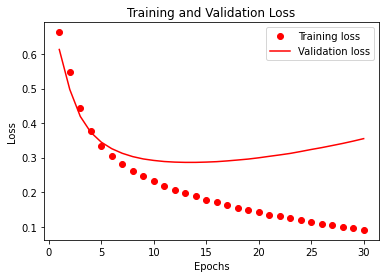

In [ ]:
epochs=range(1,len(accuracy)+1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

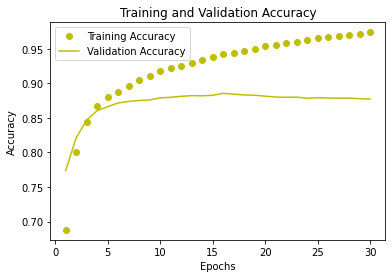

In [ ]:
#same thing for accuracy
plt.plot(epochs,accuracy,'yo',label='Training Accuracy')
plt.plot(epochs,validation_accuracy,'y',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

When looking at the graphs we can easily notice that our model performs better on training data with compared with unseen data which is validation data. It's an example of overfitting. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.
To prevent overfitting we can simply stop training when validaton accuracy no longer incerasing. We are gonna use tf.keras.callbacks.EarlyStopping callback for this purpose. And we need to add this method before training and I'm going to train new model and see how it's working. For this purpose I'm going to run my code until fitting my model and then continue to under this explanation.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping()
# This callback will stop the training when there is no improvement in the loss

In [19]:
history_with_callback=model.fit(
    train_data,
    validation_data=validation_data,
    epochs=30,
    batch_size=16,
    callbacks=[early_stopping])

Epoch 1/30
625/625 [==============================] - 10s 15ms/step - loss: 0.6621 - binary_accuracy: 0.6909 - val_loss: 0.6115 - val_binary_accuracy: 0.7726
Epoch 2/30
625/625 [==============================] - 3s 6ms/step - loss: 0.5461 - binary_accuracy: 0.8030 - val_loss: 0.4959 - val_binary_accuracy: 0.8222


As we can see above, after the second epoch it just stopped because we just used EarlyStopping with default and its patience=0 means that training is terminated as soon as the performance measure gets worse from one epoch to the next.

In [22]:
#for make your model capable of processing raw strings like simplfying the deploying we can 
#add our TextVectorization function inside our model 
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('sigmoid')
])
export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_data)
print(accuracy)


782/782 [==============================] - 8s 10ms/step - loss: 0.5016 - accuracy: 0.8127
0.8126800060272217


In [45]:
#and now we can predict our own examples
import numpy as np
test_examples=["I really love tensorflow",
               "I hate all people"]
predictions=export_model.predict(test_examples)
predictions

array([[0.59146637],
       [0.57382923]], dtype=float32)